In [1]:
import gym
import numpy as np

from collections import defaultdict, deque
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from IPython.display import clear_output

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
class MonteCarlo():
    def __init__(self, nA, gamma, epsilon_decay, epsilon_min, epsilon_max, alpha):
        '''
        params:
        nA => Size of the action space,
        gamma => Discount rate,
        epsilon, epsilon_max, epsilon_decay, epsilon_min => Used for epsilon-greedy policy,
        alpha => Used to update the values
        '''
        self.nA = nA
        self.gamma = gamma
        self.epsilon_max = epsilon_max
        self.epsilon = epsilon_max
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.alpha = alpha
        self.memory = list()
        self.Q = defaultdict(lambda: np.zeros(self.nA))

    def act(self, state):
        '''
        params:
        state => state where the agent is at,
        returns:
        action => choosed from epsilon-greedy policy
        '''

        policy = np.ones(self.nA)*(self.epsilon/self.nA)
        policy[np.argmax(self.Q[state])] = 1-self.epsilon+self.epsilon/self.nA

        return np.random.choice(np.arange(self.nA), p=policy)

    def remember(self, state, action, reward):
        self.memory.append((state, action, reward))

    def update(self, step):
        self.epsilon = self.epsilon_min + (self.epsilon_max-self.epsilon_min)*np.exp(-self.epsilon_decay*step)
        states, actions, rewards = zip(*self.memory)
        discount = np.array([self.gamma**i for i in range(len(states)+1)])
        for i in range(len(states)):
            old_Q = self.Q[states[i]][actions[i]]
            self.Q[states[i]][actions[i]] = old_Q + self.alpha * \
                (sum(rewards[i:]*discount[:len(states)-i])-old_Q)

In [4]:
rewards = deque(maxlen=500)
num_episodes = 50000
epsilon_max = 1.0
epsilon_min = 0.001
epsilon_decay = 0.0001
agent = MonteCarlo(nA=2, gamma=1.0, epsilon_decay=epsilon_decay,
                   epsilon_min=epsilon_min, epsilon_max=epsilon_max, alpha=0.1)
for i_episode in range(num_episodes):
    total_reward = 0
    state = env.reset()
    while True:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward)
        state = next_state
        total_reward += reward
        if done:
            agent.update(i_episode)
            agent.memory = []
            clear_output(True)
            rewards.append(total_reward)
            print('Episode {}/{} ... reward {} ... epsilon: {}'.format(i_episode,
                                                       num_episodes, np.mean(rewards), agent.epsilon))
            break

Episode 49999/50000 ... reward -0.038 ... epsilon: 0.007731882206648756


In [5]:
policy = dict((k,np.argmax(v)) for k, v in agent.Q.items())

In [6]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

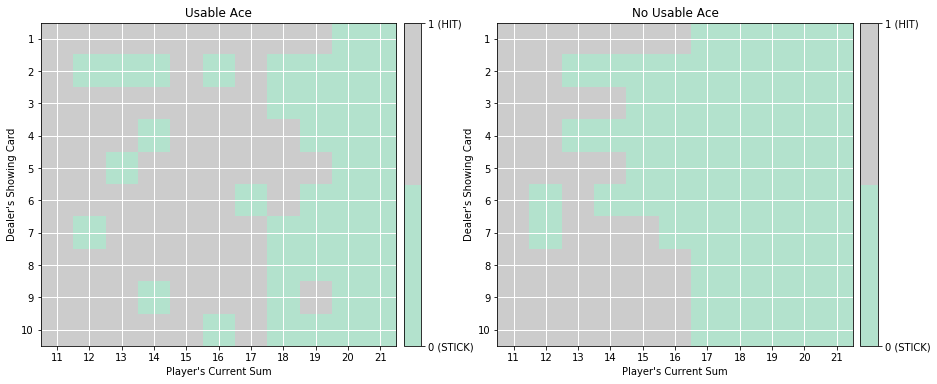

In [7]:
plot_policy(policy)